# Reinforcement Learning for the Cart-Pole

Perform approximate policy iteration in an actor-critic framework for the cart-pole (i.e., inverted pendulum on a cart).

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
import gpflow
import safe_learning
import matplotlib.pyplot as plt
import time
import os

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
from utilities import CartPole, compute_closedloop_response, get_parameter_change, find_nearest, reward_rollout, compute_roa, binary_cmap

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x


## User Options

In [2]:
class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = safe_learning.config.np_dtype,
                  tf_dtype              = safe_learning.config.dtype,
                  saturate              = True,                            # apply saturation constraints to the control input
                  eps                   = 1e-8,                            # numerical tolerance
                  use_linear_dynamics   = False,                           # use the linearized form of the dynamics as the true dynamics (for testing)
                  dpi                   = 200,
                  num_cores             = 4,
                  num_sockets           = 1)


## TensorFlow Session

Customize the TensorFlow session for the current device.

In [3]:
os.environ["KMP_BLOCKTIME"]    = str(0)
os.environ["KMP_SETTINGS"]     = str(1)
os.environ["KMP_AFFINITY"]     = 'granularity=fine,noverbose,compact,1,0'
os.environ["OMP_NUM_THREADS"]  = str(OPTIONS.num_cores)

config = tf.ConfigProto(intra_op_parallelism_threads  = OPTIONS.num_cores,
                        inter_op_parallelism_threads  = OPTIONS.num_sockets,
                        allow_soft_placement          = False,
                        device_count                  = {'CPU': OPTIONS.num_cores})

try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession(config=config)


## Dynamics

Define the nonlinear and linearized forms of the inverted pendulum dynamics.

In [4]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# System parameters
m = 0.175    # pendulum mass
M = 1.732    # cart mass
L = 0.28     # pole length
b = 0.01     # rotational friction

# State and action normalizers
x_max         = 0.5                                 # linear position [m]
theta_max     = np.deg2rad(30)                      # angular position [rad]
x_dot_max     = 2                                   # linear velocity [m/s]
theta_dot_max = np.deg2rad(30)                      # angular velocity [rad/s]
u_max         = (m + M) * (x_dot_max ** 2) / x_max  # linear force [N], control action

state_norm = (x_max, theta_max, x_dot_max, theta_dot_max)
action_norm = (u_max,)

# Dimensions and domains
state_dim     = 4
action_dim    = 1
state_limits  = np.array([[-1., 1.]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)

# Initialize system class and its linearization
cartpole = CartPole(m, M, L, b, dt, [state_norm, action_norm])
A, B = cartpole.linearize()

if OPTIONS.use_linear_dynamics:
    dynamics = safe_learning.functions.LinearSystem((A, B), name='dynamics')
else:
    dynamics = cartpole.__call__



## Reward Function

Define a positive-definite reward function over the state-action space $\mathcal{X} \times \mathcal{U}$.

In [5]:
Q = 0.1 * np.identity(state_dim).astype(OPTIONS.np_dtype)     # state cost matrix
R = 0.1 * np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix

# Quadratic reward (- cost) function
reward_function = safe_learning.QuadraticFunction(block_diag(- Q, - R), name='reward_function')


## Parametric Policy and Value Function

Define a parametric value function $V_{\bf \theta} : \mathcal{X} \to \mathbb{R}$ and policy $\pi_{\bf \delta} : \mathcal{X} \to \mathcal{U}$ as neural networks.

In [6]:
# Policy
layer_dims = [64, 64, action_dim]
activations = [tf.nn.relu, tf.nn.relu, None]
if OPTIONS.saturate:
    activations[-1] = tf.nn.tanh
policy = safe_learning.functions.NeuralNetwork(layer_dims, activations, name='policy', use_bias=False)

# Value function
layer_dims = [64, 64, 1]
activations = [tf.nn.relu, tf.nn.relu, None]
value_function = safe_learning.functions.NeuralNetwork(layer_dims, activations, name='value_function', use_bias=False)


## LQR Policy

We compare our results to the LQR solution for the linearized system later.

In [7]:
K, P = safe_learning.utilities.dlqr(A, B, Q, R)
policy_lqr = safe_learning.functions.LinearSystem((-K, ), name='policy_lqr')
if OPTIONS.saturate:
    policy_lqr = safe_learning.Saturation(policy_lqr, -1, 1)


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


## TensorFlow Graph

In [8]:
# Use parametric policy and value function
states = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
actions = policy(states)
rewards = reward_function(states, actions)
values = value_function(states)
future_states = dynamics(states, actions)
future_values = value_function(future_states)

# Compare with LQR solution, possibly with saturation constraints
actions_lqr = policy_lqr(states)
rewards_lqr = reward_function(states, actions_lqr)
future_states_lqr = dynamics(states, actions_lqr)

# Discount factor and scaling
max_state = np.ones((1, state_dim))
max_action = np.ones((1, action_dim))
r_max = np.linalg.multi_dot((max_state, Q, max_state.T)) + np.linalg.multi_dot((max_action, R, max_action.T))
gamma = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='discount_factor')

val_scaling = 1 / r_max.ravel()
pol_scaling = (1 - gamma) / r_max.ravel()

# Policy evaluation
with tf.name_scope('value_optimization'):
    value_learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    target = tf.stop_gradient(rewards + gamma * future_values, name='target')
    value_objective = pol_scaling * tf.reduce_mean(tf.abs(values - target), name='objective')
    optimizer = tf.train.GradientDescentOptimizer(value_learning_rate)
    value_update = optimizer.minimize(value_objective, var_list=value_function.parameters)

# Policy improvement
with tf.name_scope('policy_optimization'):
    policy_learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    policy_objective = - pol_scaling * tf.reduce_mean(rewards + gamma * future_values, name='objective')
    optimizer = tf.train.GradientDescentOptimizer(policy_learning_rate)
    policy_update = optimizer.minimize(policy_objective, var_list=policy.parameters)
    
# Sampling    
with tf.name_scope('state_sampler'):
    batch_size = tf.placeholder(tf.int32, shape=[], name='batch_size')
    batch = tf.random_uniform([batch_size, state_dim], -1, 1, dtype=OPTIONS.tf_dtype, name='batch')


## Approximate Policy Iteration

Train the policy $\pi_{\bf \delta}$ and value function $V_{\bf \theta}$ in tandem with approximate policy iteration. Changing the discount factor strongly affects the results; a low discount factor encourages a well-behaved value function, while a high discount factor encourages the policy to yield a larger ROA. We compare $\pi_{\bf \delta}$ to the LQR policy $\pi$ with saturation constraints, and $V_{\bf \theta}$ to the LQR value function $V_\pi$ and the value function $V_{\pi_{\bf \delta}}$ induced by the parametric policy $\pi_{\bf \delta}$. We compute $V_{\pi_{\bf \delta}}$ as a rollout sum of discounted rewards at states in a state space discretization.

### Initialization

In [9]:
session.run(tf.global_variables_initializer())

# Uniformly sampled test set
test_size = 1e3
test_set = batch.eval({batch_size: test_size})

# Keep track of the test set loss and parameter changes during training
value_test_loss = []
value_param_changes = []
policy_test_loss = []
policy_param_changes = []


### Training

In [10]:
# Training hyperparameters
max_iters    = 200
value_iters  = 100
policy_iters = 10
feed_dict = {
    states:                test_set,
    gamma:                 0.99,
    value_learning_rate:   0.2,
    policy_learning_rate:  0.5,
    batch_size:            1e2,
}

old_value_params = session.run(value_function.parameters)
old_policy_params = session.run(policy.parameters)

for i in tqdm(range(max_iters)):
    # Policy evaluation (value update)
    for _ in range(value_iters):
        feed_dict[states] = batch.eval(feed_dict)
        session.run(value_update, feed_dict)
    new_value_params = session.run(value_function.parameters)
    value_param_changes.append(get_parameter_change(old_value_params, new_value_params))
    old_value_params = new_value_params

    # Policy improvement (policy update)
    for _ in range(policy_iters):
        feed_dict[states] = batch.eval(feed_dict)
        session.run(policy_update, feed_dict)
    new_policy_params = session.run(policy.parameters)
    policy_param_changes.append(get_parameter_change(old_policy_params, new_policy_params))
    old_policy_params = new_policy_params
    
    # Record objectives
    feed_dict[states] = test_set
    value_test_loss.append(value_objective.eval(feed_dict))
    policy_test_loss.append(policy_objective.eval(feed_dict))


### Training Results

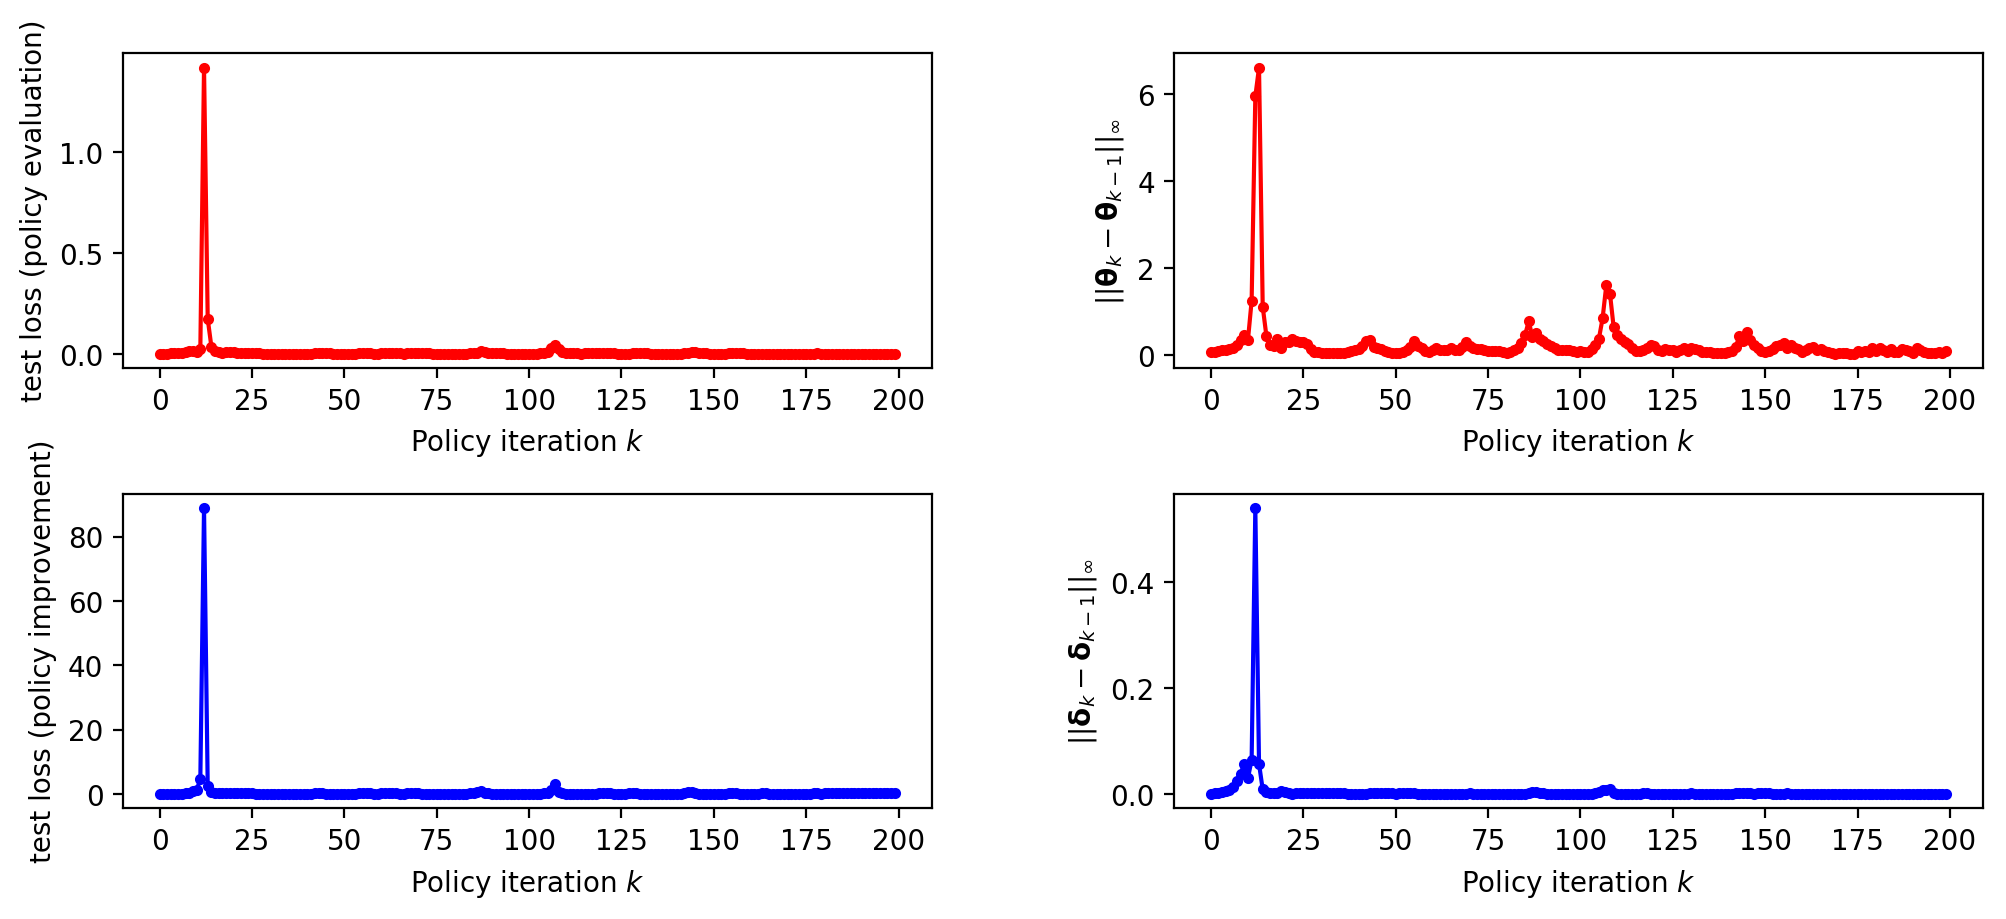

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

ax = axes[0,0]
ax.plot(value_test_loss, '.-r')
ax.set_xlabel(r'Policy iteration $k$')
ax.set_ylabel(r'test loss (policy evaluation)')

ax = axes[0,1]
ax.plot(value_param_changes, '.-r')
ax.set_xlabel(r'Policy iteration $k$')
ax.set_ylabel(r'$||{\bf \theta}_k - {\bf \theta}_{k-1}||_\infty$')

ax = axes[1,0]
ax.plot(policy_test_loss, '.-b')
ax.set_xlabel(r'Policy iteration $k$')
ax.set_ylabel(r'test loss (policy improvement)')

ax = axes[1,1]
ax.plot(policy_param_changes, '.-b')
ax.set_xlabel(r'Policy iteration $k$')
ax.set_ylabel(r'$||{\bf \delta}_k - {\bf \delta}_{k-1}||_\infty$')

plt.show()


## Estimated Value Functions and ROAs

In [12]:
# Number of states along each dimension
num_states = 51

# State grid
grid_limits = np.array([[-1., 1.], ] * state_dim)
grid = safe_learning.GridWorld(grid_limits, num_states)

# Estimate value functions and ROAs with rollout
roa_horizon     = 2000
rollout_horizon = 500
roa_tol         = 0.1
rollout_tol     = 0.01
discount        = feed_dict[gamma]  # use the same discount factor from training!
pivot_state     = np.asarray([0., 0., 0., 0.], dtype=OPTIONS.np_dtype)

# Snap pivot_state to the closest grid point
pivot_index = np.zeros_like(pivot_state, dtype=int)
for d in range(grid.ndim):
    pivot_index[d], pivot_state[d] = find_nearest(grid.discrete_points[d], pivot_state[d])

# Get 2d-planes of the discretization (x vs. v, theta vs. omega) according to pivot_state
planes = [[1, 3], [0, 2]]
grid_slices = []
for p in planes:
    grid_slices.append(np.logical_and(grid.all_points[:, p[0]] == pivot_state[p[0]], 
                                      grid.all_points[:, p[1]] == pivot_state[p[1]]).ravel())

# LQR solution (\pi and V_\pi)
closed_loop_dynamics = lambda x: future_states_lqr.eval({states: x})
reward_eval          = lambda x: rewards_lqr.eval({states: x})
true_values          = [reward_rollout(grid.all_points[mask], closed_loop_dynamics, reward_eval, discount, rollout_horizon, rollout_tol) for mask in grid_slices]
true_roas            = [compute_roa(grid.all_points[mask], closed_loop_dynamics, roa_horizon, roa_tol) for mask in grid_slices]

# Parametric policy's value function V_{\pi_\delta}
closed_loop_dynamics = lambda x: future_states.eval({states: x})
reward_eval          = lambda x: rewards.eval({states: x})
est_values           = [reward_rollout(grid.all_points[mask], closed_loop_dynamics, reward_eval, discount, rollout_horizon, rollout_tol) for mask in grid_slices]
est_roas             = [compute_roa(grid.all_points[mask], closed_loop_dynamics, roa_horizon, roa_tol) for mask in grid_slices]

# Parametric value function V_\theta
par_values = [values.eval({states: grid.all_points[mask]}) for mask in grid_slices]


/mnt/cephFS/home/pbevanda/.virtualenvs/myPyEnv/lib/python3.5/site-packages/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


Reward sums converged after 164 steps!
Reward sums converged after 198 steps!
Reward sums converged after 186 steps!
Reward sums converged after 222 steps!


### Plotting

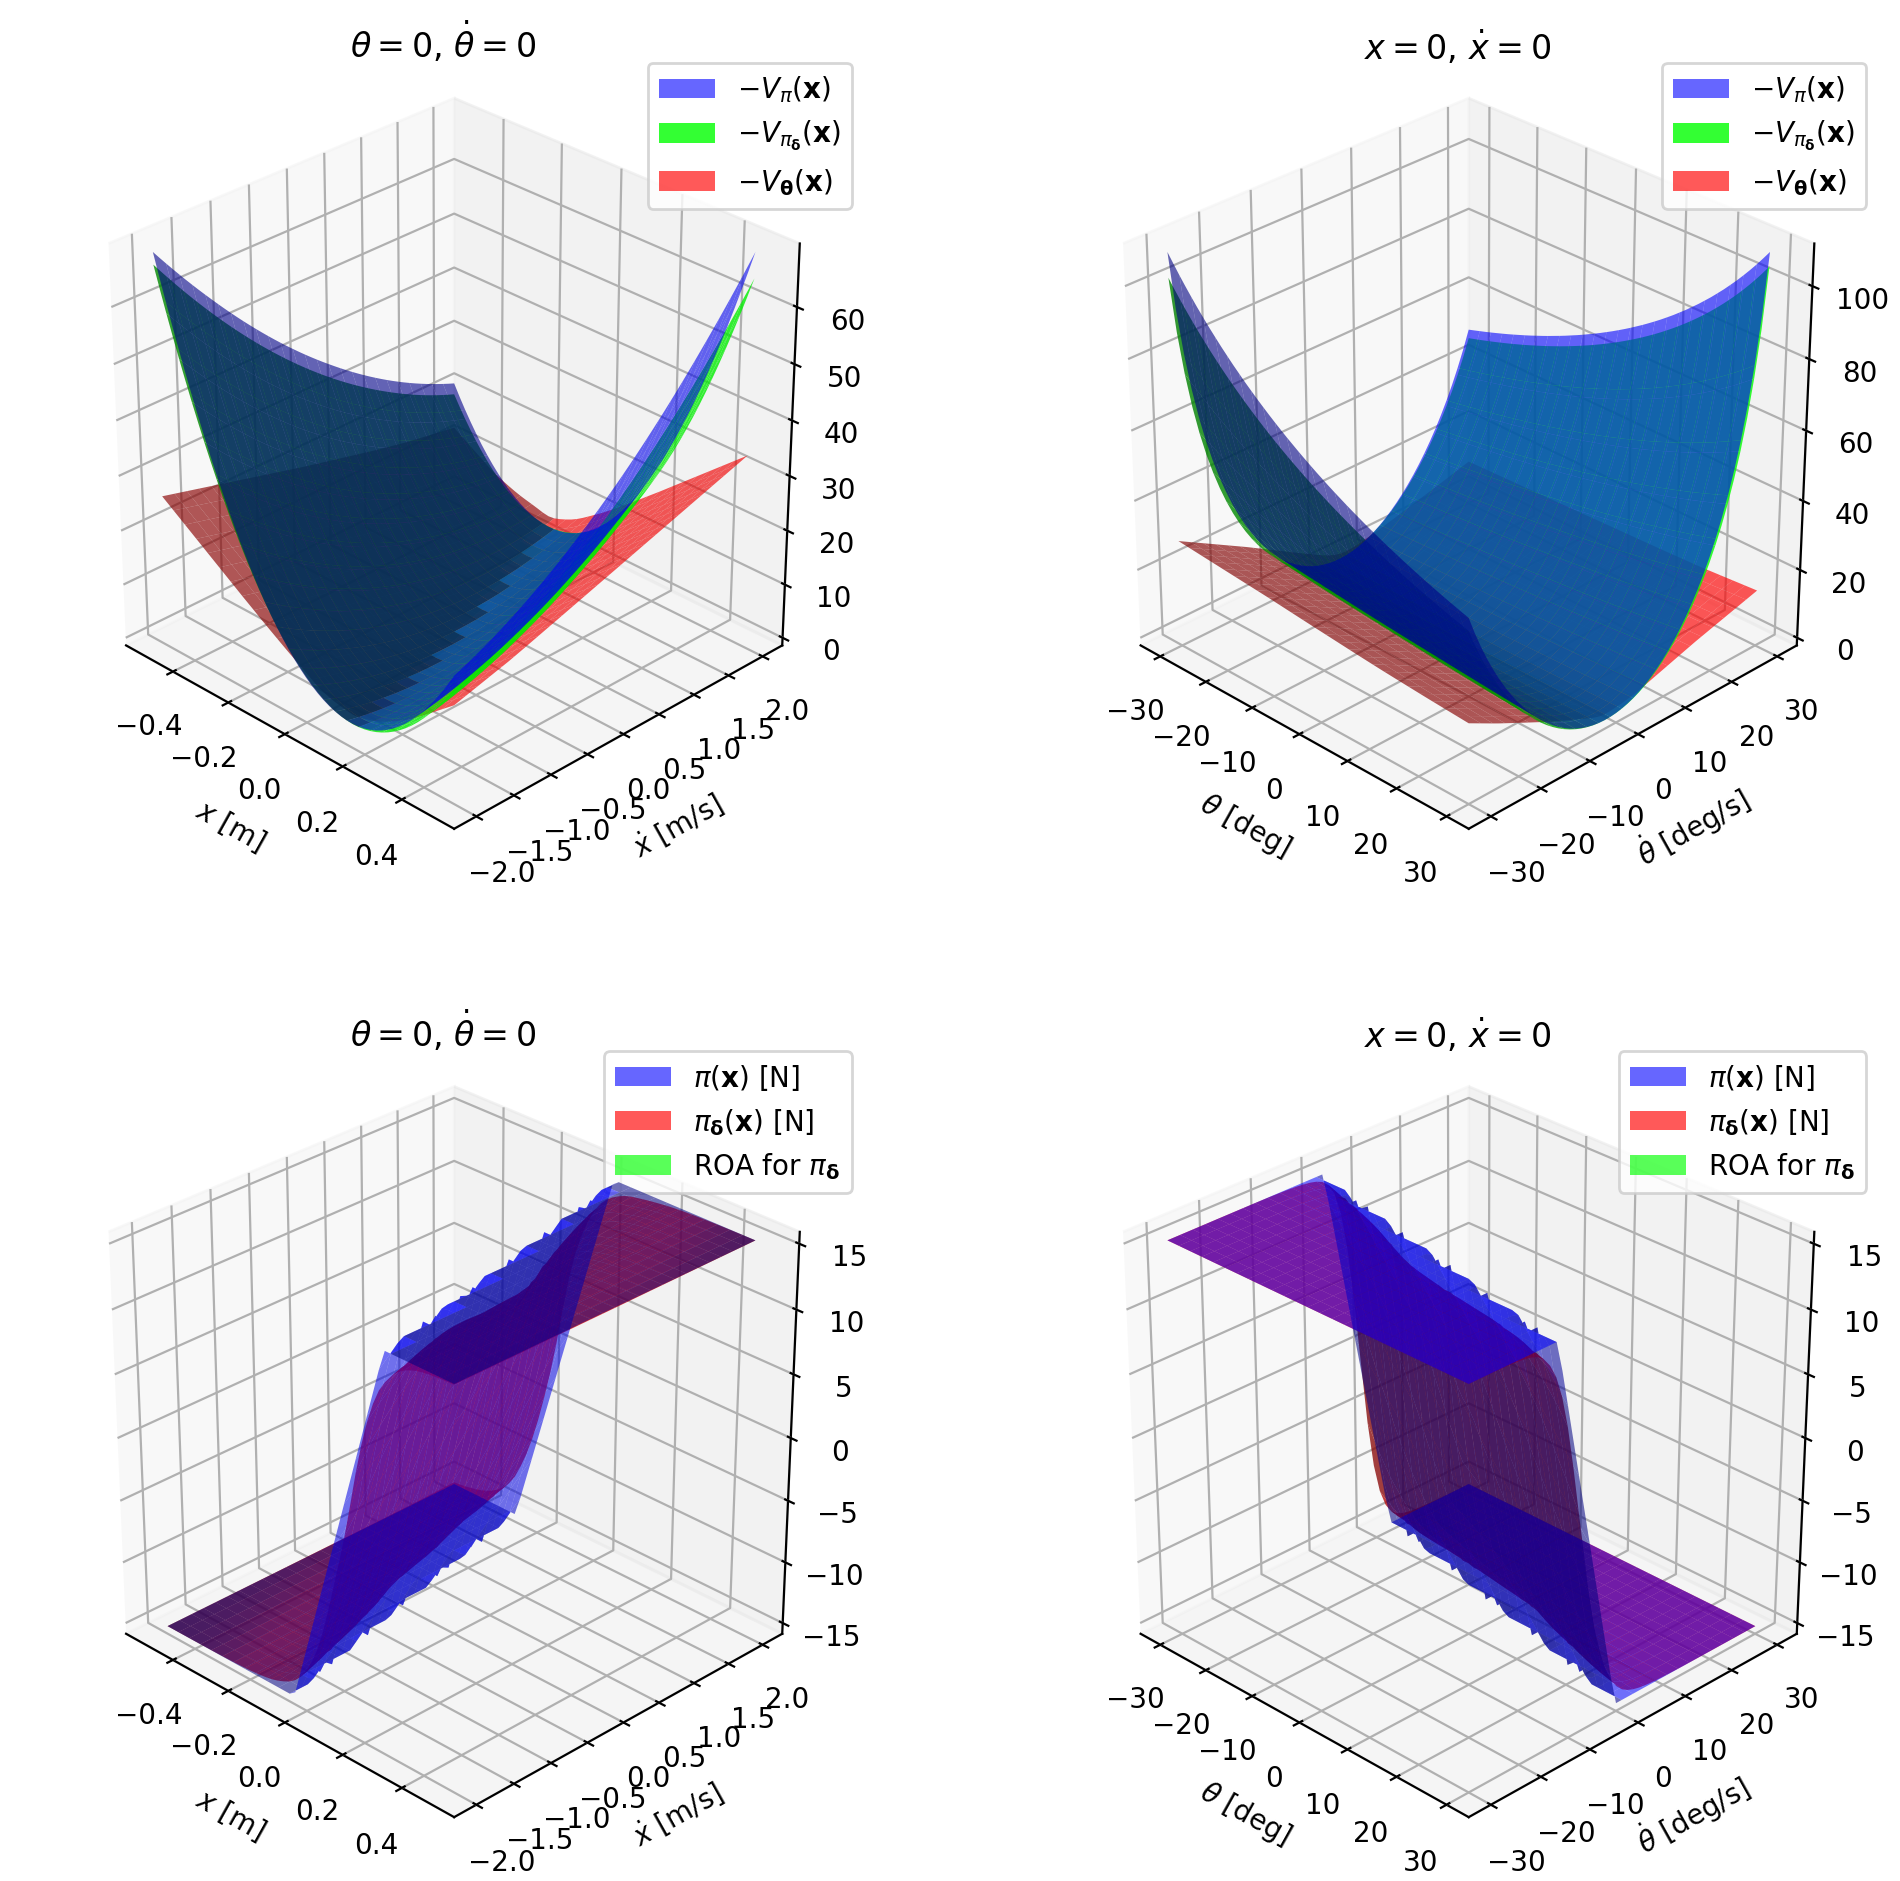

In [13]:
planes = [[0, 2], [1, 3]]
norms = np.asarray([x_max, np.rad2deg(theta_max), x_dot_max, np.rad2deg(theta_dot_max)])
scaled_discrete_points = [norm * points for norm, points in zip(norms, grid.discrete_points)]

fig = plt.figure(figsize=(12, 12), dpi=OPTIONS.dpi)

for i, p in enumerate(planes):
    ax = fig.add_subplot(221 + i, projection='3d')
    if i == 0:
        ax.set_title(r'$\theta = {:g}$'.format(pivot_state[1]) + r', $\dot\theta = {:g}$'.format(pivot_state[3]) + '\n')
        ax.set_xlabel(r'$x$ [m]')
        ax.set_ylabel(r'$\dot{x}$ [m/s]')
    else:
        ax.set_title(r'$x= {:g}$'.format(pivot_state[0]) + r', $\dot x = {:g}$'.format(pivot_state[2]) + '\n')
        ax.set_xlabel(r'$\theta$ [deg]')
        ax.set_ylabel(r'$\dot{\theta}$ [deg/s]')
    ax.view_init(None, -45)

    xx, yy = np.meshgrid(*[scaled_discrete_points[p[0]], scaled_discrete_points[p[1]]])

    for j, (values, color) in enumerate(zip([true_values, est_values, par_values], [(0, 0, 1, 0.6), (0, 1, 0, 0.8), (1, 0, 0, 0.65)])):
        z = - values[i].reshape(grid.num_points[p])
        surf = ax.plot_surface(xx, yy, z, color=color)
        surf._facecolors2d = surf._facecolors3d
        surf._edgecolors2d = surf._edgecolors3d
    proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0, 0, 1, 0.6), (0, 1, 0, 0.8), (1, 0, 0, 0.65)]]    
    ax.legend(proxy, [r'$-V_{\pi}({\bf x})$', r'$-V_{\pi_{\bf \delta}}({\bf x})$', r'$-V_{\bf \theta}({\bf x})$'])


for i, (p, mask) in enumerate(zip(planes, grid_slices)):
    ax = fig.add_subplot(223 + i, projection='3d')
    if i == 0:
        ax.set_title(r'$\theta = {:g}$'.format(pivot_state[1]) + r', $\dot\theta = {:g}$'.format(pivot_state[3]) + '\n')
        ax.set_xlabel(r'$x$ [m]')
        ax.set_ylabel(r'$\dot{x}$ [m/s]') 
    else:
        ax.set_title(r'$x= {:g}$'.format(pivot_state[0]) + r', $\dot x = {:g}$'.format(pivot_state[2]) + '\n')
        ax.set_xlabel(r'$\theta$ [deg]')
        ax.set_ylabel(r'$\dot{\theta}$ [deg/s]')
    ax.view_init(None, -45)
    
    xx, yy = np.meshgrid(*[scaled_discrete_points[p[0]], scaled_discrete_points[p[1]]])
    acts = u_max * actions.eval({states: grid.all_points[mask]})
    true_acts = u_max * actions_lqr.eval({states: grid.all_points[mask]})

    ax.plot_surface(xx, yy, true_acts.reshape(grid.num_points[p]), color='blue', alpha=0.55)
    ax.plot_surface(xx, yy, acts.reshape(grid.num_points[p]), color='red', alpha=0.75)

    z = est_roas[i].reshape(grid.num_points[p])
    ax.contourf(xx, yy, z, cmap=binary_cmap('green', 0.65), zdir='z', offset=-u_max)

    proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0, 0, 1, 0.6), (1, 0, 0, 0.65), (0., 1., 0., 0.65)]]
    ax.legend(proxy, [r'$\pi({\bf x})$ [N]', r'$\pi_{\bf \delta}({\bf x})$ [N]', r'ROA for $\pi_{\bf \delta}$'])

plt.show()
